Copyright (c) 2019 Computational-Medicine

# Multiparametric MRI - Tissue classification

I denne sesjonen vil du lære å klassifisere vev i multispektrale MR bilder ved bruk av **styrt** (supervised) **klassifikasjon**. For styrt klassifikasjon vil vi benytte treningen (i.e. treningsmasken) med seks ulike klasser (vevstyper) fra forrige sesjon og et motsvarende fire-kanaler multispektralt MR opptak. 

**THEORY**

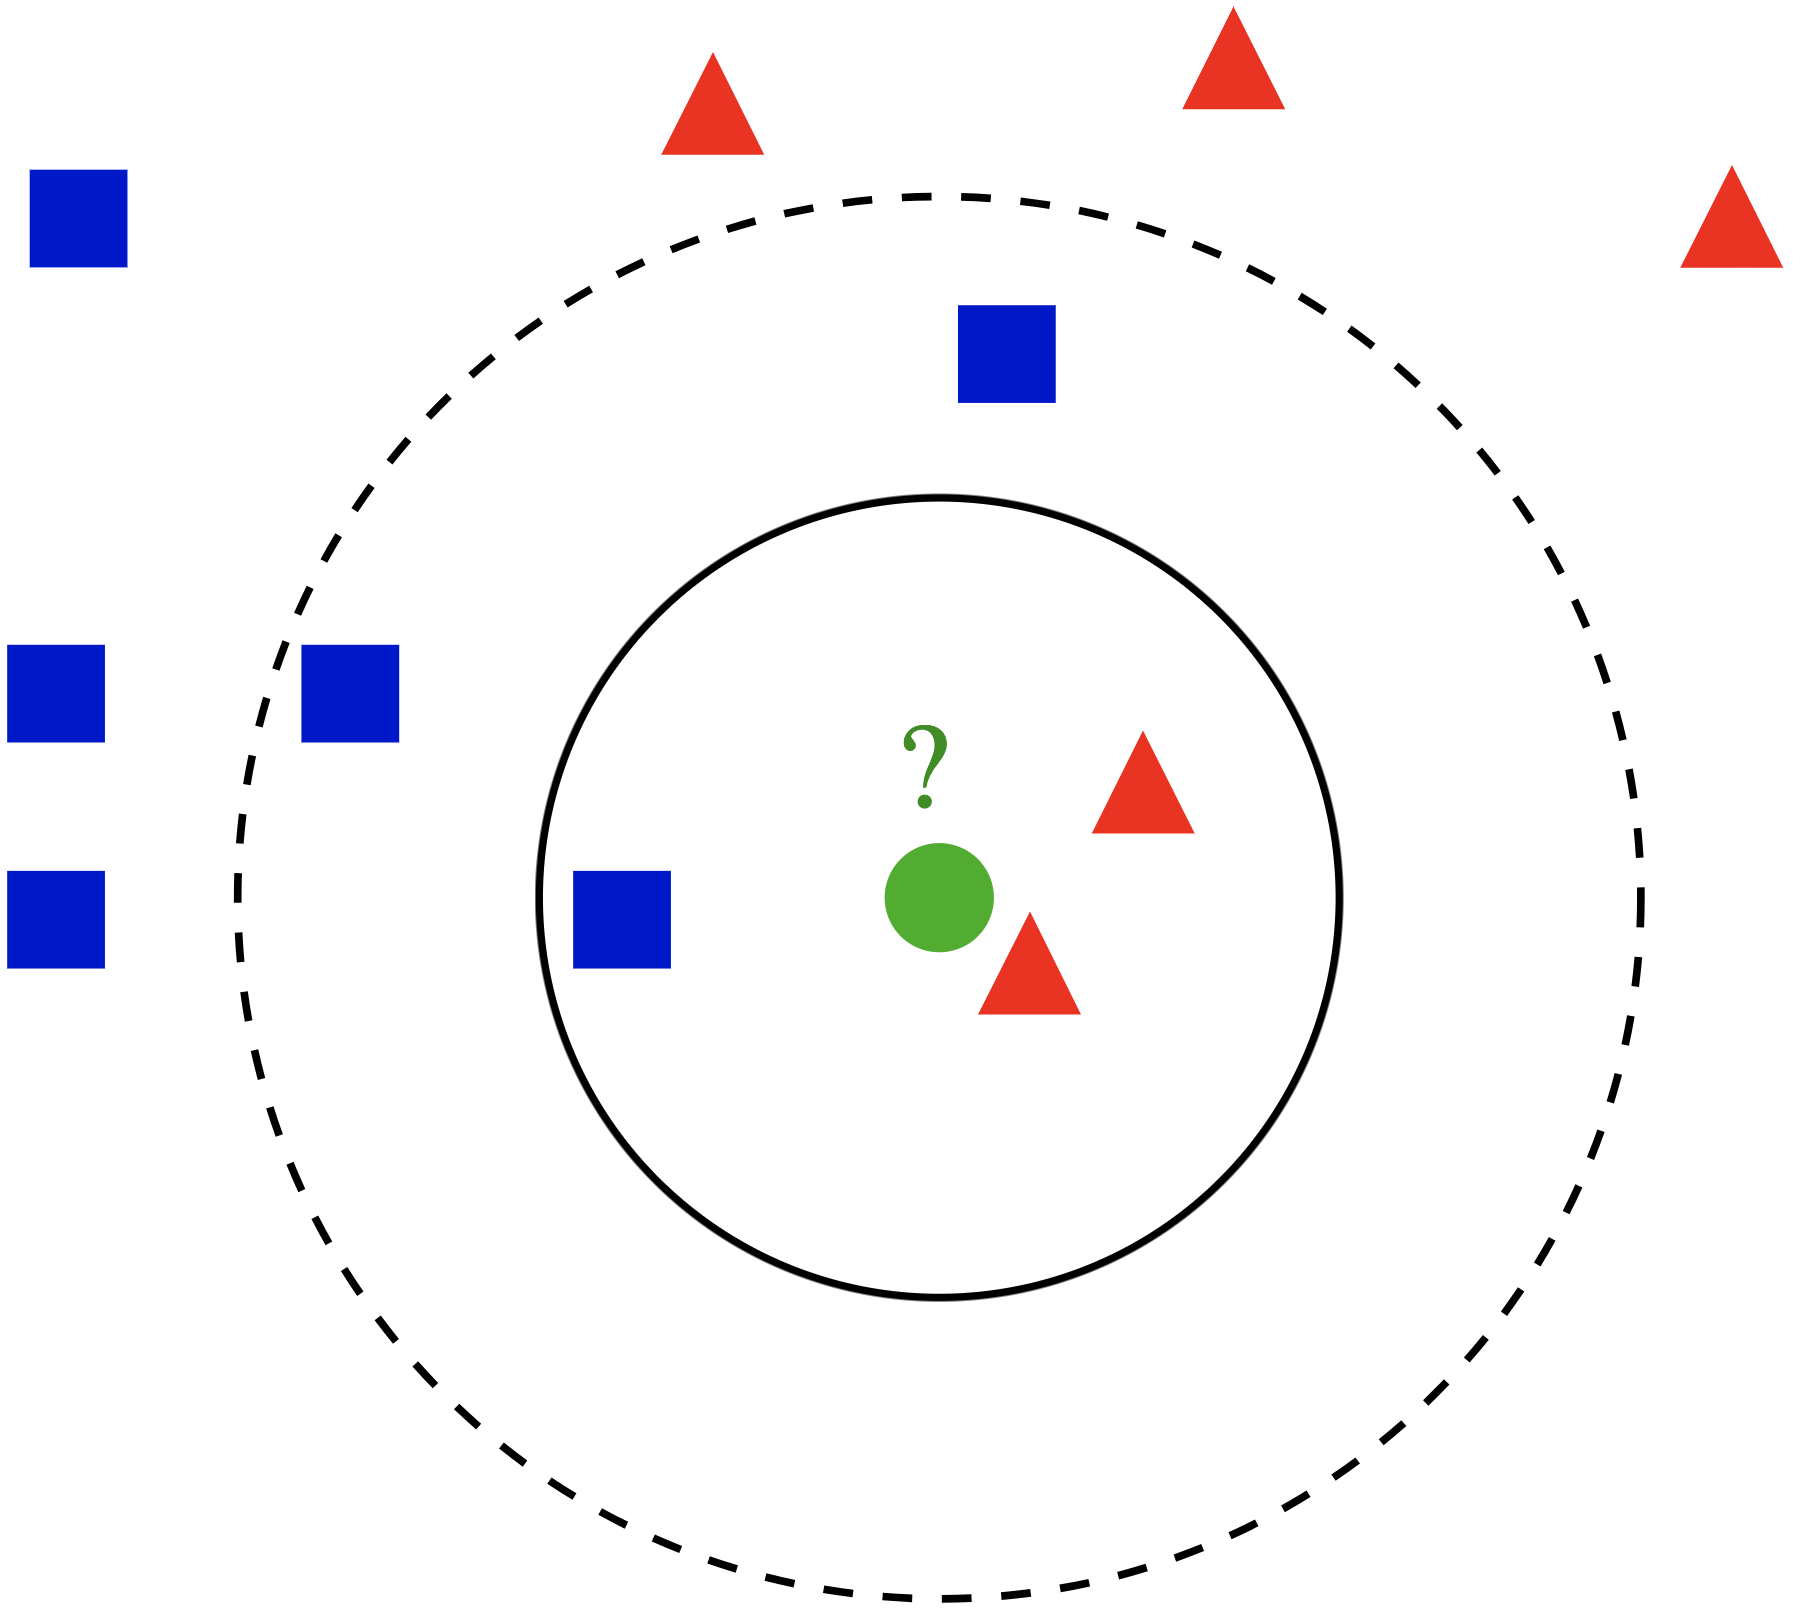

In [2]:
from IPython.display import Image
Image(filename='./assets/knn_illustration.png', width=500)

_k-NN classification example._ 

- Test-observasjonen (fylt grønn sirkel) med ukjent klasse-tilhørighet skal klassifiseres enten til klassen merket med blå kvadrater eller den andre klassen merket med røde triangler. 

- Hvis k = 3 (sirkel med heltrukken strek) vil den ukjente observasjonen tilordnes den andre klassen siden det er 2 triangler og bare 1 kvadrat innenfor den innerset sirkel med de 3 nærmeste naboer.

- Hvis k = 5 (sirkel med stiplet strek) vil den ukjente observasjonen bli tilordnet den første klassen (3 kvadrater vs. 2 triangler blant de 5 nærmeste naboer), i.e. majoritets-votering. 

- For detaljert forklaring, se [k-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) på Wikipedia

**DATA**

Figuren nedenfor viser fire-kanals multispektralt bilde (skive 60 fra et multispektral 3D opptak),  <br>
rapportert i  Lundervold et al. Volume distribution of cerebrospinal fluid using multispectral MR
imaging. <br> _Medical Image Analysis_ 2000;4:123-136. https://www.ncbi.nlm.nih.gov/pubmed/10972326, [[PDF](https://drive.google.com/file/d/17Ut1ScHU4cX5x_EHwQnNwH_q3Lgcq5WA/view)]<br>
og en manuelt tegnet trenings-maske med 6 vevstyper (farge-kodet i [R,G,B]) som følger: 

 - AIR (luft/ben) i Magenta [255,0,255]
 - GM  (grå substans) i Rød  [255,0,0] 
 - WM  (hvit substans) i Cyan [0,255,255]
 - CSF (cerebrospinalvæske) i Blå [0,0,255]
 - MUS (muskel) i Grønn [0,255,0] 
 - FAT (fett) i Gul [255,255,0]
 
**SJEKK UT:** *Multispektral MRI analyse startet med arbeidet til [Vannier et al.](https://www.ncbi.nlm.nih.gov/pubmed/3964938), Radiology 1985 - inspirert av forskning ved NASA!*

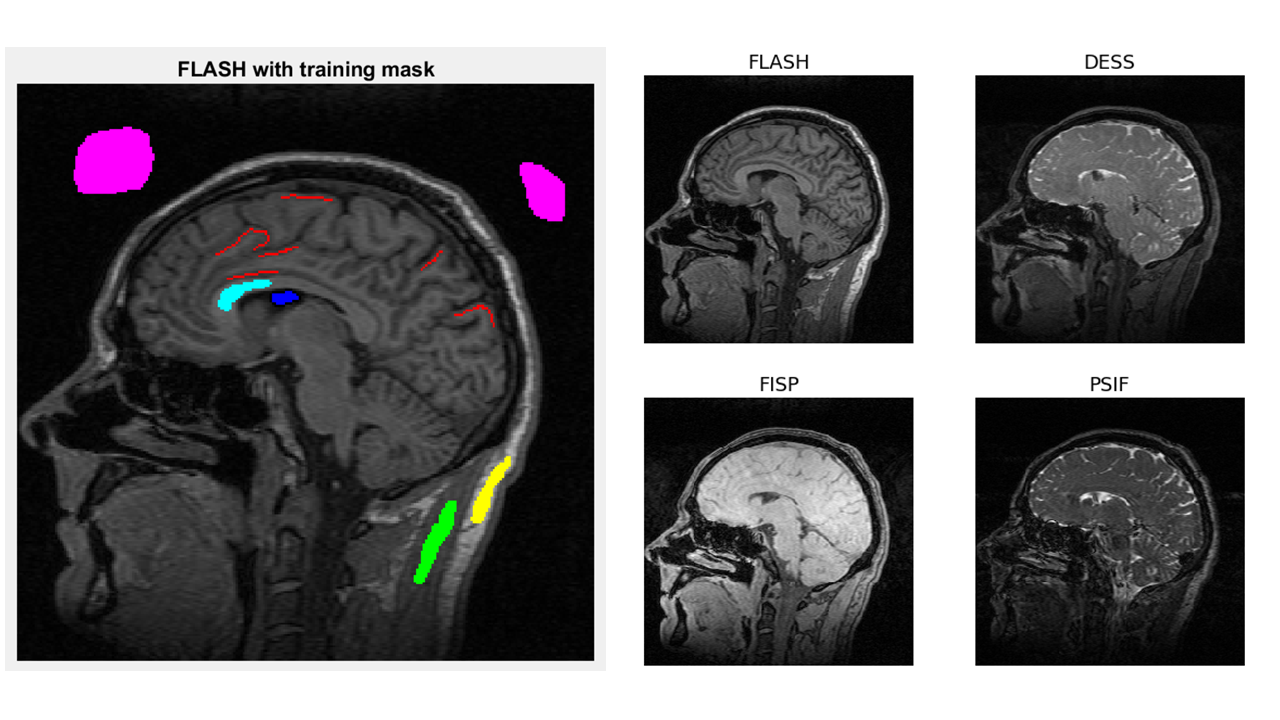

In [3]:
from IPython.display import Image
Image(filename='./assets/multispectral_tissue_classification_pptx.png', width=600)

**Importer bibliotekene som skal brukes**

In [4]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import os.path as op
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.image.image import mean_img
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
import IPython

home = os.path.expanduser('~')  # To make path to local home directory

**Definer kataloger, kanal-navn (MRI pulssekvenser) og klasse-navn (vevstyper) som inngår**

In [5]:
mydata = '../testdata'
chn_names = ['FLASH', 'DESS', 'FISP', 'PSIF']
class_names = ['air', 'gm', 'wm', 'csf', 'mus', 'fat']

## Les inn multispektralt MR bilde, fler-klasse treningsmaske og binær ROI maske

In [6]:
# Using nibabel to read the multispectral image (and the training mask)
fn_multispectral = '../data/mri/multispectral_mri.nii.gz'
img = nib.load(fn_multispectral)
fn_tmsk = '../data/mri/training_mask_1_6.nii.gz'
tmsk = nib.load(fn_tmsk)
fn_roimsk = '../data/mri/brain_roi_mask.nii.gz'
roimsk = nib.load(fn_roimsk)

In [7]:
print('**Multispectral image info:**')
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
data = img.get_data()
print('min = %.1f' % data.min())
print('max = %.1f' % data.max())
print('number of channels =', img.shape[-1])
# Collaps the singular (z-)dimension
img_data = np.uint16(data.squeeze())
print('shape of 2D+spectral img_data = ',img_data.shape)
print('dtype of 2D+spectral img_data = ',img_data.dtype)
print('img affine:', img.affine)

**Multispectral image info:**
shape of image =  (256, 256, 1, 4)
units =  ('unknown', 'unknown')
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype = float64
min = 0.0
max = 493.0
number of channels = 4
shape of 2D+spectral img_data =  (256, 256, 4)
dtype of 2D+spectral img_data =  uint16
img affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


og tilhørende treningsmaske

In [8]:
print('**Training mask info:**')
print('shape = ', tmsk.header.get_data_shape())
print('voxel size = ', tmsk.header.get_zooms())
print('dtype tmsk = %s' % tmsk.header.get_data_dtype())
tmsk_data = tmsk.get_data().squeeze()
print('min mask value = %.0f' % tmsk_data .min())
print('max mask value = %.0f' % tmsk_data .max())
print('shape of 2D tmsk_data = ', tmsk_data.shape)
print('tmsk affine:', tmsk.affine)

**Training mask info:**
shape =  (256, 256, 1, 1)
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype tmsk = int16
min mask value = 0
max mask value = 6
shape of 2D tmsk_data =  (256, 256)
tmsk affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


samt ROI masken

In [9]:
print('**Brain ROI mask info:**')
print('shape = ', roimsk.header.get_data_shape())
print('voxel size = ', roimsk.header.get_zooms())
print('dtype roimsk = %s' % roimsk.header.get_data_dtype())
roimsk_data = roimsk.get_data().squeeze()
print('min mask value = %.0f' % roimsk_data .min())
print('max mask value = %.0f' % roimsk_data .max())
print('shape of 2D roimsk_data = ', roimsk_data.shape)
print('roimsk affine:', roimsk.affine)

**Brain ROI mask info:**
shape =  (256, 256, 1, 1)
voxel size =  (1.0, 1.0, 1.4, 1.0)
dtype roimsk = int16
min mask value = 0
max mask value = 1
shape of 2D roimsk_data =  (256, 256)
roimsk affine: [[   0.            0.            1.39999998    0.        ]
 [   1.            0.           -0.          256.        ]
 [   0.            1.            0.         -511.        ]
 [   0.            0.            0.            1.        ]]


**Vis det multispektrale MRI bildet**

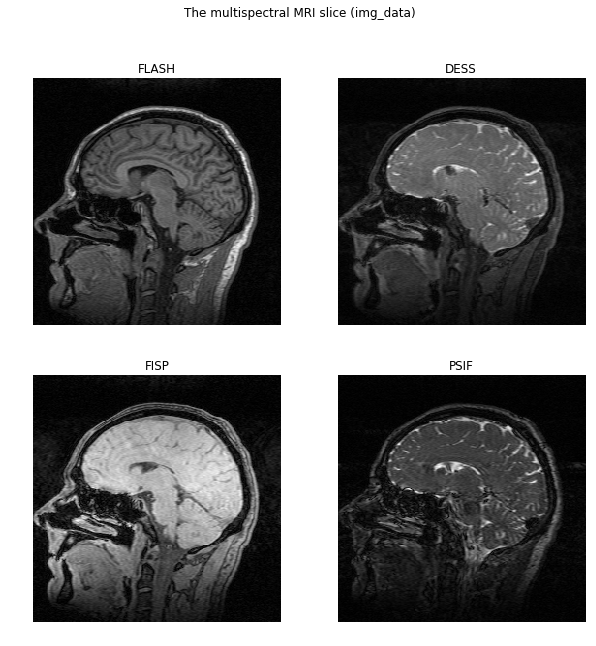

In [10]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
ax = axes.ravel()
for k, ch in enumerate(chn_names):
    ax[k].imshow(img_data[:, :, k].T, cmap='gray', origin='lower')
    ax[k].set_title(ch)
    ax[k].set(xlabel="")
    ax[k].axis('off')
plt.suptitle("The multispectral MRI slice (img_data)") 
plt.tight_layout
plt.show()

**Vis treningsmasken med farge-koding av klassene (i henhold til en egen-definert fargetabell)**

In [11]:
import matplotlib
col_code = {
    'BCK': [255,255,255], # White (background)
    'AIR': [255,0,255],   # Magenta 
    'GM':  [255,0,0],     # Red 
    'WM':  [0,255,255],   # Cyan 
    'CSF': [0,0,255],     # Blue 
    'MUS': [0,255,0],     # Green 
    'FAT': [255,255,0]    # Yellow 
}
cla_names = list(col_code.keys())
ncla = len(cla_names)
colors = np.array(list(col_code.values()))/255   # scale to interval 0-1
mycmap = matplotlib.colors.ListedColormap(colors)
cla_cmap = matplotlib.cm.get_cmap(mycmap, ncla)   # ncla discrete colors

In [12]:
cla_names_num = []
for i in range(ncla):
    str = cla_names[i] + ' [%d]' % (i)
    cla_names_num.append(str)
cla_names_num

['BCK [0]', 'AIR [1]', 'GM [2]', 'WM [3]', 'CSF [4]', 'MUS [5]', 'FAT [6]']

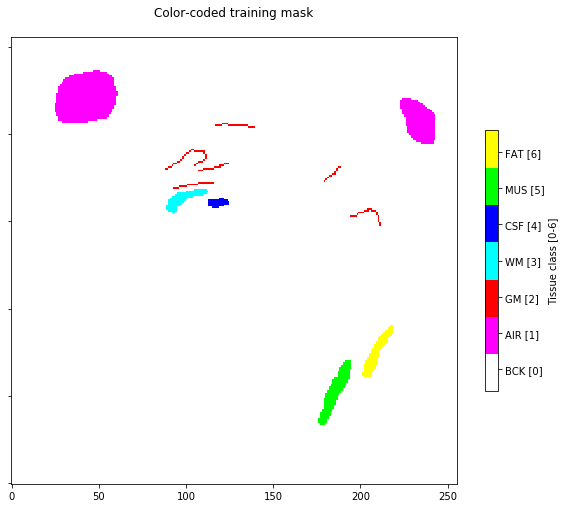

In [13]:
fig, ax = plt.subplots(figsize=(10,12))

cmsk = ax.imshow(tmsk_data[:, :].T)
clim=cmsk.properties()['clim']
cax = ax.imshow(tmsk_data[:, :].T, cmap=cla_cmap, origin='lower', clim=clim)
ax.set_title('Color-coded training mask\n')
ax.axis('on')
ax.set_yticklabels("")
#ax.set_xticklabels("")
cbar = fig.colorbar(cax, shrink=0.4, label='Tissue class [0-%d]' % clim[1]) 
tick_locs = np.linspace(clim[0]+0.5, clim[1]-0.5, ncla)
cbar.set_ticks(tick_locs)
cbar.ax.set_yticklabels(cla_names_num)
plt.tight_layout
plt.show()

#fig.savefig('%s/prj/ELMED219/results/training_mask_1_6_color_coded.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

## Lager et data frame FVB direkte fra MRI data (`img`) og treningsmasken (`tmsk`)

In [14]:
# Find pixel locations corresponding to AIR (class 1), GM (class 2), ..., FAT (class 6)
frames = pd.DataFrame()   # Create an empty data frame
for cn, cla in enumerate(class_names):
    ind = np.where(tmsk_data == cn+1)  # Find indices (x,y) for given class, class numbers start at 1 (not 0)
    df = pd.DataFrame(np.asarray(img_data[ind[0][:],ind[1][:],:]), columns = chn_names)
    df.insert(len(df.columns), 'Class', class_names[cn].upper())  # Last entry is class name
    frames = frames.append(df)
FVB = pd.concat([frames], ignore_index=True)
print(FVB.head())
print(FVB.tail())
# Class-specific statistics of FVB accross the different features (channels)
#FVB.groupby('Class').describe(percentiles = [0.5]).round(3).T

   FLASH  DESS  FISP  PSIF Class
0      7     6    10     2   AIR
1      0     6     8     0   AIR
2      8     2     4    11   AIR
3      3     7     2    11   AIR
4      5     3     0     6   AIR
      FLASH  DESS  FISP  PSIF Class
1981    281    60   167   176   FAT
1982    305    58   167   164   FAT
1983    303    53   172   185   FAT
1984    281    65   145   176   FAT
1985    287    53   148   214   FAT


**Lagrer data frame FVB som en .csv file**

In [15]:
FVB.to_csv('../data/mri/multispectral_mri_training_data_from_nifti_mask.csv', index=False)

## Styrt klassifikasjon med k-nærmeste nabo (kNN)

Se også https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/


### Treningsdata

**Les inn lagret FVB data frame med labelede treningsdata**

In [16]:
FVB = pd.read_csv('../data/mri/multispectral_mri_training_data_from_nifti_mask.csv')
FVB.head()

,FLASH,DESS,FISP,PSIF,Class
0,7,6,10,2,AIR
1,0,6,8,0,AIR
2,8,2,4,11,AIR
3,3,7,2,11,AIR
4,5,3,0,6,AIR


**Preprosessering: Skill ut data matrise X (i float) og tilhørende klasser y fra FVB data frame**

In [17]:
X_train = FVB.iloc[:, :-1].values.astype(float)
y_train = FVB.iloc[:, -1].values                 # Last column is 'Class'

### Testdata hentet fra brain ROI masken

Last inn masken med brain ROI

In [18]:
fn_roimsk = '../data/mri/brain_roi_mask.nii.gz'
roimsk = nib.load(fn_roimsk)
roimsk_data = roimsk.get_data().squeeze()
# roimsk_data = np.ones(roimsk_data.shape)   # Using the whole image as ROI

Finn alle pixel-lokasjonene i ROI for å hente ut testdata **X_test** og lagre testdata og tilhørende pixel-lokasjon som et pandas data frame

In [19]:
# Find pixel locations corresponding to brain ROI (verdi 1) 
ind_test = np.where(roimsk_data == 1) 
X_test = np.asarray(img_data[ind_test[0][:],ind_test[1][:],:]) # The multispectral signal intensities
dfT = pd.DataFrame(X_test, columns = chn_names)
dfT.insert(loc = len(dfT.columns),
           column = 'row',
           value = ind_test[0])  # Row of pixel location
dfT.insert(loc = len(dfT.columns),
           column = 'col',
           value = ind_test[1])  # Col of pixel location

In [20]:
dfT.head()

,FLASH,DESS,FISP,PSIF,row,col
0,149,66,67,66,20,121
1,129,90,86,106,20,122
2,101,83,146,81,20,123
3,28,79,158,40,20,124
4,7,53,155,67,20,125


In [21]:
dfT.tail()

,FLASH,DESS,FISP,PSIF,row,col
35817,10,13,29,6,239,150
35818,8,18,29,6,239,151
35819,12,18,20,8,239,152
35820,0,20,25,16,239,153
35821,9,26,19,19,239,154


### Skalering av egenskapene (MRI signalintensitet, kanal for kanal) i trening- og test data

In [22]:
scaler = StandardScaler()  
scaler.fit(X_train.astype(float))

X_train_scaled = scaler.transform(X_train.astype(float))  
X_test_scaled = scaler.transform(X_test.astype(float)) 

# Make data frame from pair of scaled X_train og y_train to check scaling
dX = pd.DataFrame(X_train_scaled, columns=chn_names)
dy = pd.DataFrame(y_train, columns=['Class'])
FVB_train = pd.concat([dX, dy], axis=1)
FVB_train.describe(percentiles = [0.5]).round(4).T

,count,mean,std,min,50%,max
FLASH,1986.0,0.0,1.0003,-0.7119,-0.6019,3.4196
DESS,1986.0,-0.0,1.0003,-0.7713,-0.5691,5.0273
FISP,1986.0,0.0,1.0003,-0.8068,-0.6583,2.4738
PSIF,1986.0,0.0,1.0003,-0.6589,-0.5347,5.3990


### Estimer en k nærmeste nabo klassifikator (KNN) for (ikke-skalerte) treningsdata

In [23]:
K = 13
classifier = KNeighborsClassifier(n_neighbors=K)  
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='uniform')

Prediksjon på treningsdata

In [24]:
y_train_pred = classifier.predict(X_train) 

Evaluering med **forvirringsmatrise**

In [25]:
print(confusion_matrix(y_train, y_train_pred))  
print(classification_report(y_train, y_train_pred)) 

[[1250    0    0    0    0    0]
 [   0   51    0    0    0    0]
 [   0    0  170    0    0    0]
 [   0    0    0  136    0    0]
 [   0    0    0    0  250    0]
 [   0    0    0    1    0  128]]
              precision    recall  f1-score   support

         AIR       1.00      1.00      1.00      1250
         CSF       1.00      1.00      1.00        51
         FAT       1.00      1.00      1.00       170
          GM       0.99      1.00      1.00       136
         MUS       1.00      1.00      1.00       250
          WM       1.00      0.99      1.00       129

   micro avg       1.00      1.00      1.00      1986
   macro avg       1.00      1.00      1.00      1986
weighted avg       1.00      1.00      1.00      1986



**Din tur!**

 - Eksperimentér med ulike K-verdier (K=1, 5, 27, 51) og sjekk forvirringsmatrisen.
 
 - Hvorfor er vi garantert å få en diagnonal forvirringsmatrise med K=1 ?

Vi setter nå initialt K=5 og bruker skalerte signalintensiteter - "zero mean unit variance" over alle klasser  

In [26]:
K = 5
classifier = KNeighborsClassifier(n_neighbors=K)
classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

### Prediksjon på brain ROI (X_test)

In [27]:
y_pred = classifier.predict(X_test_scaled)

In [28]:
print('Number of classified pixels:', len(y_pred))
print('The first 10 predictions in ROI:', y_pred[:10])

Number of classified pixels: 35822
The first 10 predictions in ROI: ['MUS' 'MUS' 'MUS' 'MUS' 'MUS' 'MUS' 'CSF' 'CSF' 'AIR' 'AIR']


Lag et pandas data frame for prediksjonen for senere å omdøpe vevstyper til numerisk koding ved bruk av en dictionary

In [29]:
df_y_pred = pd.DataFrame(y_pred,  columns=['Class'])
print(df_y_pred.info())
df_y_pred.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35822 entries, 0 to 35821
Data columns (total 1 columns):
Class    35822 non-null object
dtypes: object(1)
memory usage: 279.9+ KB
None


,0,1,2,3,4
Class,MUS,MUS,MUS,MUS,MUS


In [30]:
df_y_pred.tail().T

,35817,35818,35819,35820,35821
Class,AIR,AIR,AIR,AIR,AIR


Konstruksjon av dictionary som  knytter vevstype-navn til vevstype-nummer

In [31]:
cla_code = {
    'BCK': 0, # White (background)  Color-coding according to cla_cmap defined above
    'AIR': 1, # Magenta 
    'GM':  2, # Red 
    'WM':  3, # Cyan 
    'CSF': 4, # Blue 
    'MUS': 5, # Green 
    'FAT': 6  # Yellow 
}

df_y_pred['Class'] = df_y_pred['Class'].map(cla_code) # note: if the dictionary does not exhaustively map all
                                             # entries then non-matched entries are changed to NaNs

**Velg FLASH-kanalen for å superponere vevsklasse-prediksjonen**

In [32]:
# Adding max classnumber + 1 to the FLASH data to avoid mixing data values with predicted class-numbers
cla_data = np.int16((img_data[:,:,0].copy().squeeze() + (df_y_pred.values.max() + 1)*np.ones(tmsk_data.shape)))
mx = cla_data.max()
mn = cla_data.min()
print('min - max =', mn, '-', mx)

cla_data = cla_data/mx
mx = cla_data.max().round(4)
mn = cla_data.min().round(4)
print('min - max =', mn, '-', mx)
cla_data.shape


min - max = 7 - 364
min - max = 0.0192 - 1.0


(256, 256)

Fyll cla_data med de pixel-vise KNN prediksjoner (skalert ned til intervallet [0, 1] )

In [33]:
mx = df_y_pred['Class'].values.max()  # Max class value
cla_data[dfT['row'].values, dfT['col'].values] = df_y_pred['Class'].values / mx

### Inspiser prediksjonen i farge-koding og i grånivå-koding av vevstypene

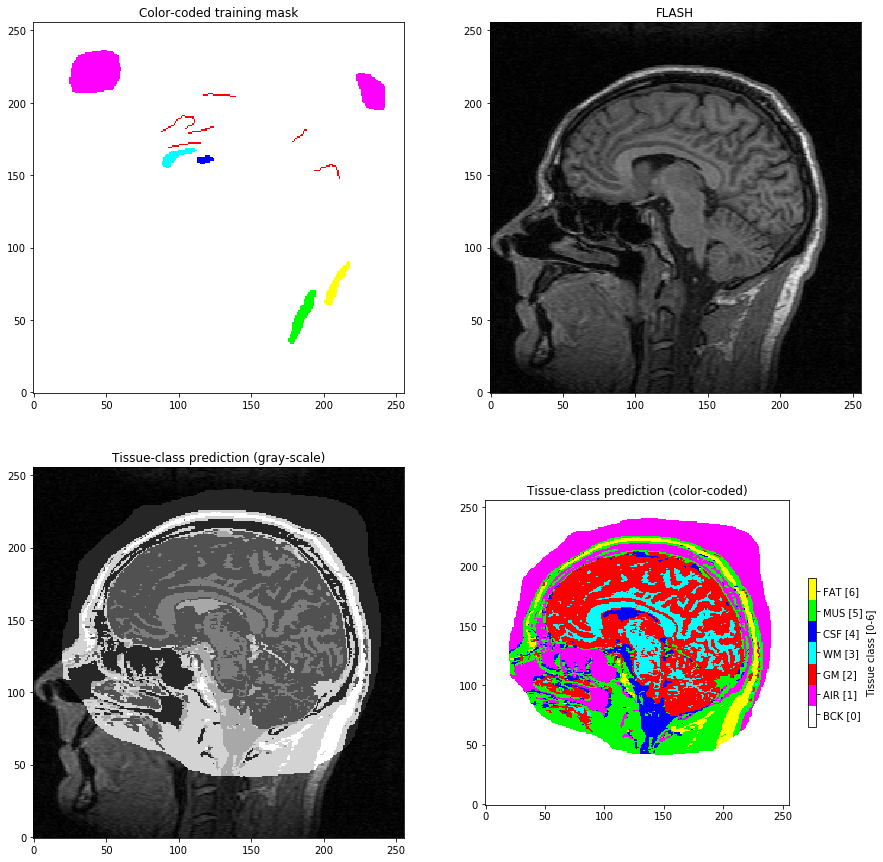

In [34]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
ax = axes.ravel()

ax[0].imshow(tmsk_data[:, :].T, cmap=cla_cmap, origin='lower')
ax[0].set_title('Color-coded training mask')
ax[0].axis('on')

ax[1].imshow(img_data[:, :, 0].squeeze().T, cmap='gray', origin='lower')
ax[1].set_title('FLASH')

# Hadamar (elemnt-wise) product np.multiply(a,b)
ax[2].imshow(cla_data[:, :].T / mx, cmap='gray', origin='lower')
ax[2].set_title('Tissue-class prediction (gray-scale)')

ax[3].imshow(np.multiply(cla_data[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[3].set_title('Tissue-class prediction (color-coded)')

cbar = fig.colorbar(cax, shrink=0.4, label='Tissue class [0-%d]' % clim[1]) 
tick_locs = np.linspace(clim[0]+0.5, clim[1]-0.5, ncla)
cbar.set_ticks(tick_locs)
cbar.ax.set_yticklabels(cla_names_num)

plt.show()

fig.savefig('%s/prj/ELMED219/results/KNN_classification_results_on_flash.png' % (home),
           transparent=False, dpi=300, bbox_inches="tight")

Experiments with a **Random Forest** classifier, where the labels are converted to numeric

In [35]:
df_y_train = pd.DataFrame(y_train,  columns=['Class'])
print(df_y_train.info())
df_y_train.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 1 columns):
Class    1986 non-null object
dtypes: object(1)
memory usage: 15.6+ KB
None


,0,1,2,3,4
Class,AIR,AIR,AIR,AIR,AIR


In [36]:
df_y_train['Class'] = df_y_train['Class'].map(cla_code)
y_train_num = df_y_train['Class'].values

In [37]:
classifierRF = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [38]:
classifierRF.fit(X_train_scaled, y_train_num)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [39]:
y_pred_rf = classifierRF.predict(X_test_scaled)

Fyll data med de pixel-vise RF prediksjoner (skalert ned til intervallet [0, 1] )

In [40]:
mx = df_y_pred['Class'].values.max()  # Max class value
cla_data_rf = cla_data.copy()
cla_data_rf[dfT['row'].values, dfT['col'].values] = y_pred_rf / mx

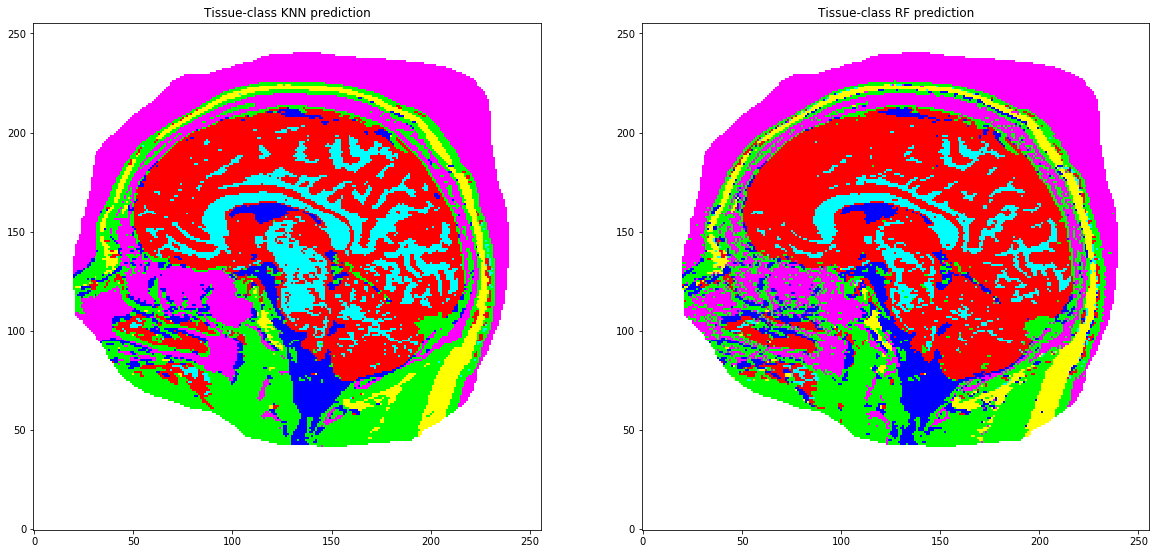

In [41]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
ax = axes.ravel()
ax[0].imshow(np.multiply(cla_data[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[0].set_title('Tissue-class KNN prediction')
ax[1].imshow(np.multiply(cla_data_rf[:, :].T, roimsk_data[:, :].T) / mx, cmap=cla_cmap, origin='lower')
ax[1].set_title('Tissue-class RF prediction')
plt.show()


Evaluer resultatet - forvirringsmatrise mellom KNN (y_pred_knn) og RF klassifikasjon (y_pred_rf)

In [42]:
from utils import plot_confusion_matrix, plot_confusion_matrix_with_colorbar

In [43]:
y_pred_knn = df_y_pred['Class'].values

In [44]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_knn, y_pred_rf)

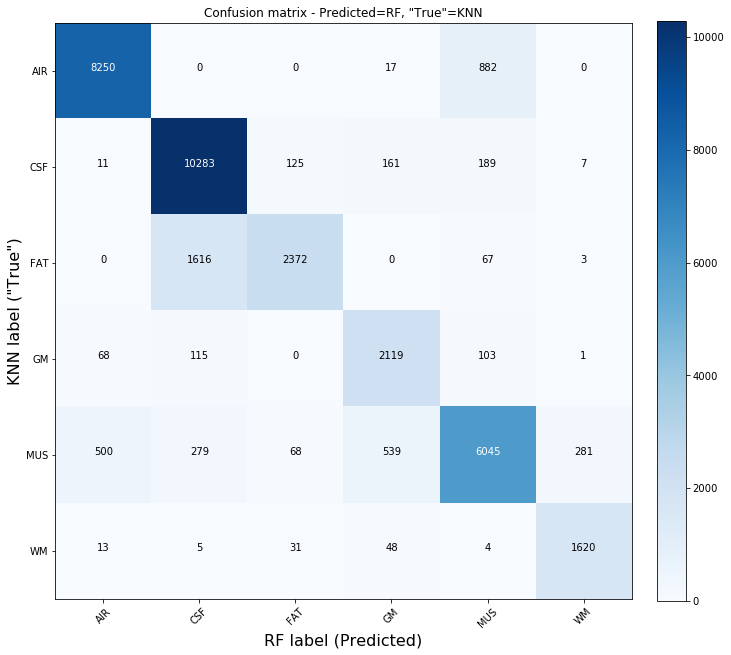

In [46]:
plot_confusion_matrix_with_colorbar(cm, classes=np.unique(y_pred), title='Confusion matrix - Predicted=RF, "True"=KNN', figsize=(10,10))
plt.ylabel('KNN label ("True")')
plt.xlabel('RF label (Predicted)')
plt.show()